# Kaggle competition: Tabular Playground Series - Jan 2021 (Post competition notebook)
## This notebook achieves a leadearbord Private Score (RMSE) of 0.69651 (position 352 of 1728 participants, which corresponds to top 20.4%)
## Note that top position scores vary by very small amounts. For example, a decrease in my RMSE of 0.00151 would have put me in 4th place.
### Supervised machine learning regression problem
#### This project consists in predicting a continuous target with a dataset with 14 continuous features. We are given no information on what each variable measures.
#### For more information see: https://www.kaggle.com/competitions/tabular-playground-series-jan-2021/overview

#### Notebook author: Arnau Juanmarti
#### Last edited: March 13, 2023

## Table of Contents

* [0 SETTINGS](#0)
* [1 EXPLORATORY DATA ANALYSIS](#1)
	* [1.1 Visualization of target](#11)
	* [1.2 Distribution of features and relationship with target](#12)
	* [1.3 Scatterplots of the features with the target](#13)
* [2 PREPROCESSING](#2)
	* [2.1 Outliers](#21)
	* [2.2 Feature Engineering](#22)
		* [2.2.1 Generate discretized features using distribution components](#221)
		* [2.2.2 Create peak features for capturing vertical patterns in feature and target interactions (no improvement therefore not used)](#222)
		* [2.2.3 Create argmin and argmax features from continuous features (no improvement therefore not used)](#223)
		* [2.2.4 Statistical features](#224)
	* [2.3 Scaling](#23)
* [3 MODELING](#3)
	* [3.1 Base models](#31)
		* [3.1.1 Ridge](#311)
		* [3.1.2 LGBM](#312)
	* [3.2 Automatic feature selection with Recursive Feature Elimination (RFE)](#32)
	* [3.3 Final models](#33)
		* [3.3.1 Ridge](#331)
			* [3.3.1.1 Hyperparameter optimization](#3311)
			* [3.3.1.2 Transforming data to a high-dimensional sparse representation](#3312)
			* [3.3.1.3 Training and predicting](#3313)
		* [3.3.2 Lasso](#332)
			* [3.3.2.1 Training and predicting](#3321)
		* [3.3.3 LGBM](#333)
			* [3.3.3.1 Hyperparameter optimization](#3331)
			* [3.3.3.2 Training and predicting](#3332)
		* [3.3.4 CatBoost](#334)
			* [3.3.4.1 Hyperparameter optimization](#3341)
			* [3.3.4.2 Training and predicting](#3342)
		* [3.3.5 XGBoost](#335)
			* [3.3.5.1 Hyperparameter optimization](#3351)
            * [3.3.5.2 Training and predicting](#3352)
	* [3.4 Ensemble](#34)
		* [3.4.1 Optimizing weights](#341)
		* [3.4.2 Showing the out-of-fold scores and calculating the final ensemble test predictions](#342)
* [4 SUBMISSION](#4)

# 0 SETTINGS <a class='anchor' id='0'></a>

#### 0.1 Specify notebook settings

In [1]:
## This is to make output cells scrollable horizontally when output does not fit the screen.
#from IPython.display import display, HTML
#display(HTML("<style>pre { white-space: pre !important; }</style>"))

## This is to ensure imported custom modules get loaded automatically when the module is edited.
%load_ext autoreload
%autoreload 2

#### 0.2 Specify project directory

In [2]:
import os
os.chdir('C:/Users/Arnau Juanmarti/machinelearning_projects/Kaggle Competitions/TPS Jan 2021 Regression')

#### 0.3 Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import own_functions as own ## Module with own custom functions
from own_functions import df_summary
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.feature_selection import RFECV
import optuna
import pickle
from sklearn.ensemble import RandomTreesEmbedding
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

#### 0.4 Specify pandas display options

In [4]:
desired_width=320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns',50)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

#### 0.5 Import data

In [5]:
train = pd.read_csv('Original data/tabular-playground-series-jan-2021/train.csv')
test = pd.read_csv('Original data/tabular-playground-series-jan-2021/test.csv')
sample_submission = pd.read_csv('Original data/tabular-playground-series-jan-2021/sample_submission.csv')

#### 0.6 Tagging variables

In [6]:
id = 'id'
target = 'target'
cont_cols = [f'cont{i}' for i in range(1, 15, 1)]

In [7]:
df_summary(train)

Number of rows: 300000


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,300000,0,0.0,"[1, 3, 4, 5, 8]"
cont1,float64,299865,0,0.0,"[0.6703898514390889, 0.3880525276975261, 0.8349504778390991, 0.8207081542149183, 0.93527823044286]"
cont2,float64,299906,0,0.0,"[0.8112995057309422, 0.6211042271574185, 0.2274363757909521, 0.1601550295645752, 0.4212353750611798]"
cont3,float64,299745,0,0.0,"[0.6439683093331412, 0.6861020924830562, 0.3015838588756856, 0.5468871637084558, 0.3038008503606239]"
cont4,float64,299892,0,0.0,"[0.2917913764510022, 0.5011490796546958, 0.293408406815278, 0.7261044189928849, 0.8802143269344298]"
cont5,float64,299730,0,0.0,"[0.2841173764699329, 0.6437895146086654, 0.6068394934817684, 0.2824437687875619, 0.6656103512736972]"
cont6,float64,299830,0,0.0,"[0.8559531758452059, 0.449804950718596, 0.8291750847270303, 0.7851078217967621, 0.8301305276393726]"
cont7,float64,299876,0,0.0,"[0.8907004183744506, 0.5108237501974809, 0.5061434957864068, 0.7527582756179138, 0.4871129085404026]"
cont8,float64,299853,0,0.0,"[0.2855421109796029, 0.5807482361435341, 0.5587710129561313, 0.8232666215088326, 0.6041573087129861]"
cont9,float64,299651,0,0.0,"[0.5582454418515085, 0.4183350707888616, 0.5876031455771054, 0.5744662376705533, 0.8746584038465337]"


In [8]:
df_summary(test)

Number of rows: 200000


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,200000,0,0.0,"[0, 2, 6, 7, 10]"
cont1,float64,199933,0,0.0,"[0.3536003960677555, 0.9072220265000728, 0.1792871822942601, 0.3593847738079436, 0.3357908000487838]"
cont2,float64,199957,0,0.0,"[0.7387802758490386, 0.1897563814383314, 0.3553530531578394, 0.1810492738729861, 0.6826067981433357]"
cont3,float64,199886,0,0.0,"[0.6009390681938437, 0.2155307618999736, 0.6239720943689671, 0.5513678956221049, 0.6764807780727788]"
cont4,float64,199957,0,0.0,"[0.2933767919383172, 0.8699151545898112, 0.4378122234293921, 0.2063863808638485, 0.2194650387083545]"
cont5,float64,199871,0,0.0,"[0.285691162675836, 0.3013333859421893, 0.2824757730595917, 0.2807625823956033, 0.2828612800430481]"
cont6,float64,199936,0,0.0,"[0.4580063448350751, 0.5289578658101766, 0.3208258655352028, 0.4820755220283451, 0.581720896787479]"
cont7,float64,199947,0,0.0,"[0.620703563617202, 0.3903509900795343, 0.3867886527820846, 0.5066773482428131, 0.7486392593895049]"
cont8,float64,199935,0,0.0,"[0.4222487709348951, 0.5211120354698421, 0.7764221942761969, 0.3627925784349201, 0.350158127024225]"
cont9,float64,199835,0,0.0,"[0.3692033022080026, 0.7947789056868737, 0.2222678530279728, 0.3797373249796229, 0.4489147019808153]"


## 1 EXPLORATORY DATA ANALYSIS <a class='anchor' id='1'></a>

### 1.1 Visualization of target <a class='anchor' id='11'></a>

((array([-4.58129856, -4.39228306, -4.28980121, ...,  4.28980121,  4.39228306,  4.58129856]),
  array([ 0.        ,  3.7004589 ,  4.25620738, ..., 10.22754135, 10.24000319, 10.2675685 ])),
 (0.7290609376247601, 7.905661328316823, 0.9945158423076625))

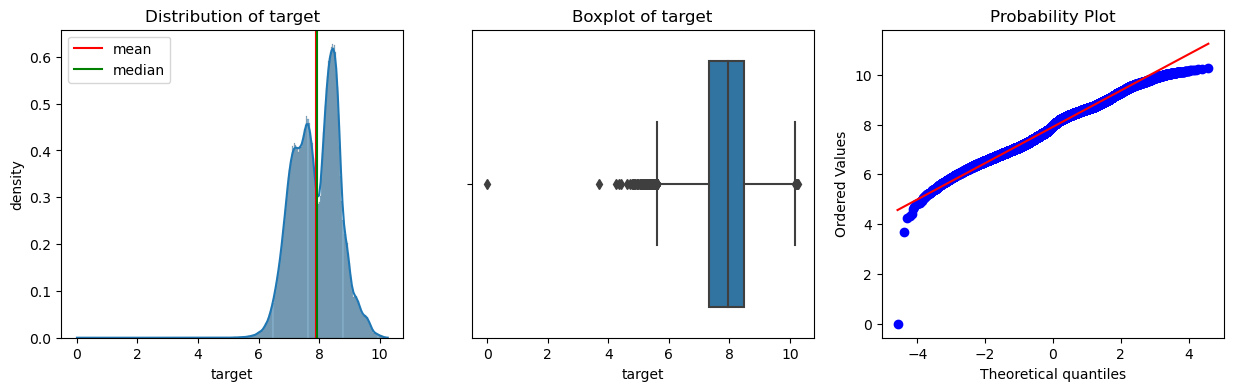

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(train[target], stat='density', kde=True, ax=axs[0])
axs[0].axvline(x = np.mean(train[target]), color = 'red', label = 'mean')
axs[0].axvline(x = np.median(train[target]), color = 'green', label = 'median')
axs[0].set(xlabel=target, ylabel='density', title='Distribution of target')
axs[0].legend()
sns.boxplot(data=train, x=target, ax=axs[1])
axs[1].set(title='Boxplot of target')
stats.probplot(train[target], plot=axs[2])

#### Takeaways:
1. The target has a bimodal distribution. Taking this into account will probably be important for model performance.
2. The target has two outliers. We will drop them.

### 1.2 Distribution of features and relationship with target <a class='anchor' id='12'></a>
The following figure shows the distribution of each feature for both train and test sets and a (binned) scatterplot of the feature with the target.

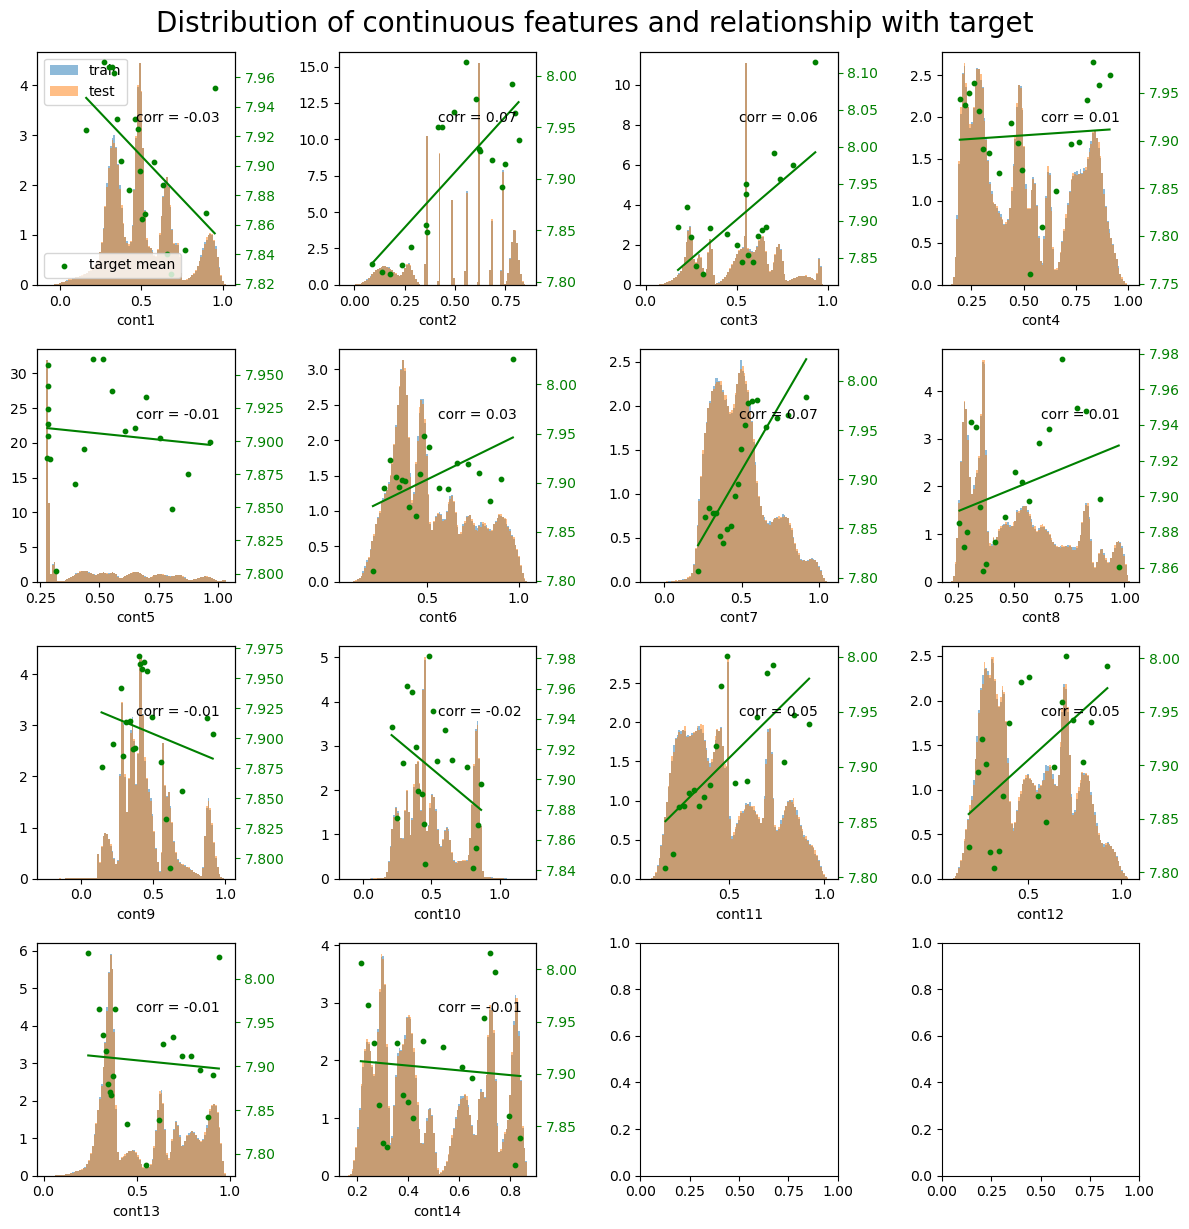

In [10]:
own.plot_cont_target_cont_all(train, test, cont_cols, target, rows=4, cols=4, num_bins1=100, num_bins2=20, figsize=(12, 12))

#### Takeaways:
1. All of the features have multimodal distributions. Some of them have several peaks (data concentrated arround several values). This points us to possibilities for feature engineering.
2. All of the features have a small correlation with the target. This indicates that probably tree-based models will work better than linear models.

### 1.3 Scatterplots of the features with the target <a class='anchor' id='13'></a>
The following figure shows scatterplots of each feature with the target with a fitted regression line.

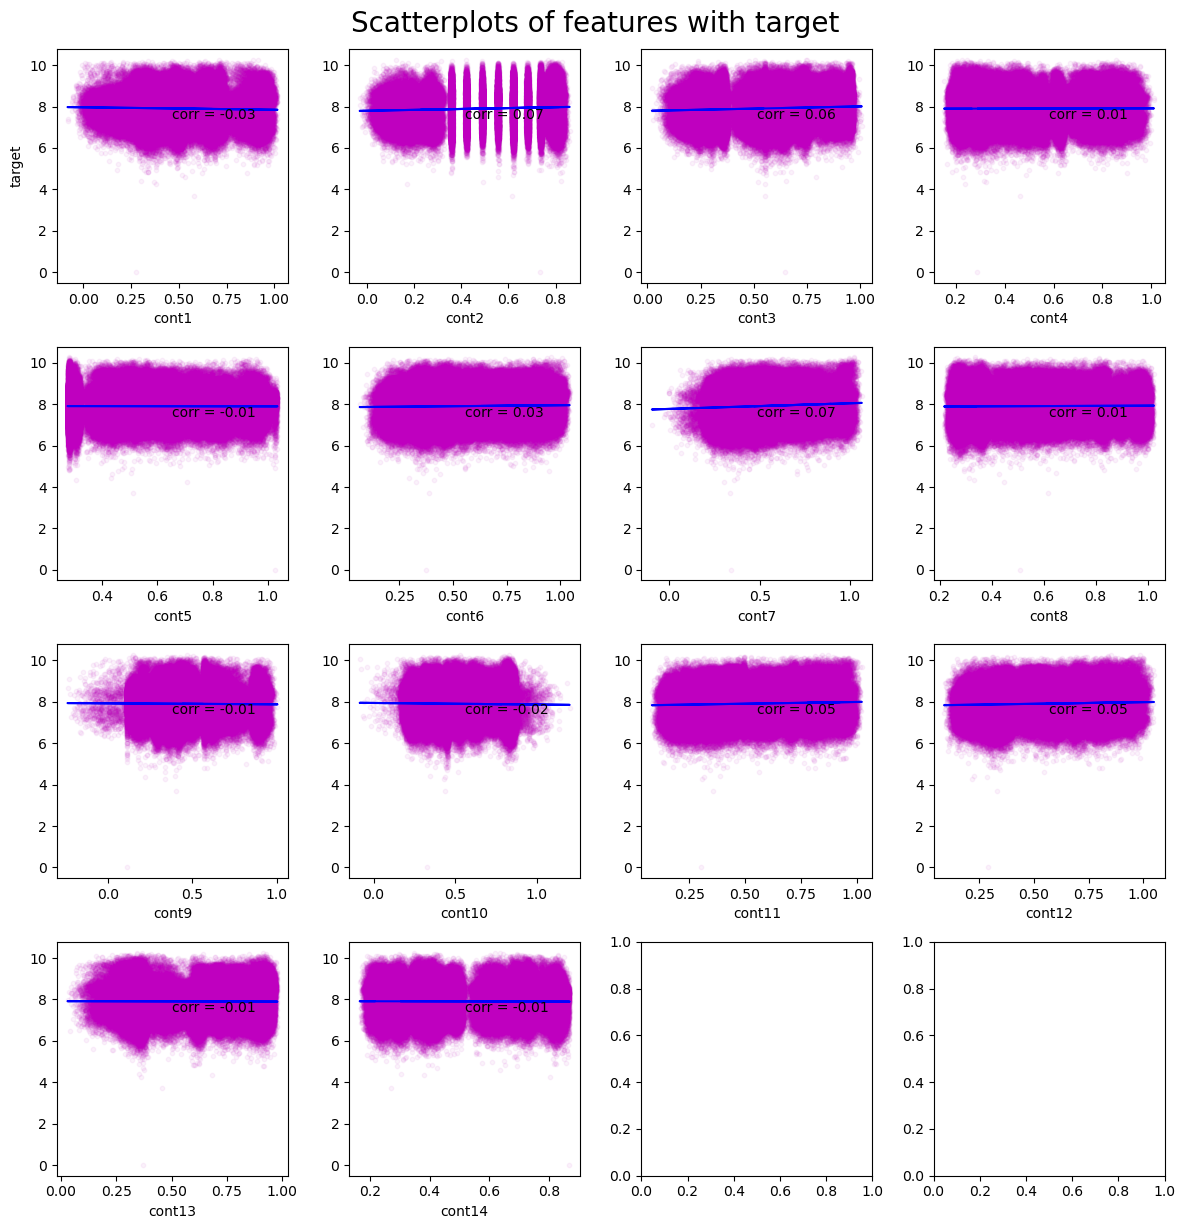

In [11]:
own.scatterplot_features_target(train, cont_cols, target, 4, 4, figsize=(12, 12))

#### Takeaways:
1. The figure confirms that all features have a small correlation with the target.

## 2 PREPROCESSING <a class='anchor' id='2'></a>

### 2.1 Outliers <a class='anchor' id='21'></a>
Let's drop the two outliers in the target identified before.

In [12]:
outlier_idx = train[train[target] < 4].index
train.drop(outlier_idx, inplace=True)
train.reset_index(drop=True, inplace=True)

### 2.2 Feature Engineering <a class='anchor' id='22'></a>

#### 2.2.1 Generate discretized features using distribution components <a class='anchor' id='221'></a>
Exploiting the fact that the features have multimodal distributions, we generate new discrete features indicating the distribution components of each feature. To identify the distribution components we use a GaussianMixture model.

Idea from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

In [13]:
n_component_mapping = {
            1: 4,
            2: 10,
            3: 6,
            4: 4,
            5: 3,
            6: 2,
            7: 3,
            8: 4,
            9: 4,
            10: 8,
            11: 5,
            12: 4,
            13: 6,
            14: 6
        }

for i in range(1, 15):
    gmm = GaussianMixture(n_components=n_component_mapping[i], random_state=100)            
    gmm.fit(pd.concat([train[f'cont{i}'], test[f'cont{i}']], axis=0).values.reshape(-1, 1))
            
    train[f'cont{i}_class'] = gmm.predict(train[f'cont{i}'].values.reshape(-1, 1))
    test[f'cont{i}_class'] = gmm.predict(test[f'cont{i}'].values.reshape(-1, 1))

gmm_features = [f'cont{i}_class' for i in range(1, 15)]
features = cont_cols + gmm_features

#### 2.2.2 Create peak features for capturing vertical patterns in feature and target interactions (no improvement therefore not used) <a class='anchor' id='222'></a>
For the features that contain most clear peaks, generate new binary features indicating whether the row pertains to a peak.

Idea from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

In [14]:
'''
for df in [train, test]:
    df['cont2_peak'] = ((train['cont2'].round(2) == 0.36) | (train['cont2'].round(2) == 0.42) | (train['cont2'].round(2) == 0.49) |\
                        (train['cont2'].round(2) == 0.55) | (train['cont2'].round(2) == 0.56) | (train['cont2'].round(2) == 0.62) |\
                        (train['cont2'].round(2) == 0.68) | (train['cont2'].round(2) == 0.74)).astype(np.uint8)
            
    df['cont5_peak'] = (train['cont5'].round(2) == 0.28).astype(np.uint8)
            
peak_features = ['cont2_peak', 'cont5_peak']
features += peak_features
'''

"\nfor df in [train, test]:\n    df['cont2_peak'] = ((train['cont2'].round(2) == 0.36) | (train['cont2'].round(2) == 0.42) | (train['cont2'].round(2) == 0.49) |                        (train['cont2'].round(2) == 0.55) | (train['cont2'].round(2) == 0.56) | (train['cont2'].round(2) == 0.62) |                        (train['cont2'].round(2) == 0.68) | (train['cont2'].round(2) == 0.74)).astype(np.uint8)\n            \n    df['cont5_peak'] = (train['cont5'].round(2) == 0.28).astype(np.uint8)\n            \npeak_features = ['cont2_peak', 'cont5_peak']\nfeatures += peak_features\n"

#### 2.2.3 Create argmin and argmax features from continuous features (no improvement therefore not used) <a class='anchor' id='223'></a>
Idea from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

In [15]:
'''
for df in [train, test]:
    df['cont_argmin'] = np.argmin(df[cont_cols].values, axis=1)
    df['cont_argmax'] = np.argmax(df[cont_cols].values, axis=1)
            
idx_features = ['cont_argmin', 'cont_argmax']
features += idx_features
'''

"\nfor df in [train, test]:\n    df['cont_argmin'] = np.argmin(df[cont_cols].values, axis=1)\n    df['cont_argmax'] = np.argmax(df[cont_cols].values, axis=1)\n            \nidx_features = ['cont_argmin', 'cont_argmax']\nfeatures += idx_features\n"

#### 2.2.4 Statistical features <a class='anchor' id='224'></a>
Let's create statistical summary features of the continuous features to see if we gain information.

In [16]:
for df in [train, test]:
    df['cont_sum'] = df[cont_cols].sum(axis=1)
    df['cont_mean'] = df[cont_cols].mean(axis=1)
    df['cont_std'] = df[cont_cols].std(axis=1)
    df['cont_min'] = df[cont_cols].min(axis=1)
    df['cont_max'] = df[cont_cols].max(axis=1)

statistical_features = ['cont_sum', 'cont_mean', 'cont_std', 'cont_min', 'cont_max']
features += statistical_features

### 2.3 Scaling <a class='anchor' id='23'></a>
Scaling the continuous features

In [17]:
scale_features = cont_cols
sc = StandardScaler()

train[scale_features] = sc.fit_transform(train[scale_features])
test[scale_features] = sc.transform(test[scale_features])

## 3 MODELING <a class='anchor' id='3'></a>

### 3.1 Base models <a class='anchor' id='31'></a>
Let's start with a linear model (Ridge) and a tree-based model (LGBM) without parameter tuning. The preprocessing steps above have been checked in these models to see if they improve performance.

#### 3.1.1 Ridge <a class='anchor' id='311'></a>
We use random 5-fold cross-validation and get the test predictions from averaging the predictions calculated with the models trained on each fold.

In [18]:
fold_scores = []
preds_test_ridge_base = np.zeros(test.shape[0])
importances_list = []

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
    X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
    X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
    
    model = Ridge(random_state=100, alpha=7000)
    model.fit(X_train, y_train)
    
    pred_val = model.predict(X_val)
    
    pred_test = model.predict(test[features])
    preds_test_ridge_base += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    importances_list.append(model.coef_.ravel())
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')

FOLD 0 SCORE: 0.7232041936473018
FOLD 1 SCORE: 0.7229820513420581
FOLD 2 SCORE: 0.7223195200865952


KeyboardInterrupt: 

##### Feature importances

In [ ]:
importance_mean = np.absolute(np.mean(np.array(importances_list), axis=0))
importances_df = pd.DataFrame({'feature': features, 'importance': importance_mean}).sort_values('importance', ascending=False)
plt.figure(figsize=(14, 9))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.gca().invert_yaxis()
plt.title('Ridge Regression Feature Importances')
plt.xlabel('Importance score')
plt.ylabel('Feature')

#### 3.1.2 LGBM <a class='anchor' id='312'></a>

In [ ]:
fold_scores = []
preds_test_lgbm_base = np.zeros(test.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
    X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
    X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
    
    model = LGBMRegressor(random_state=100, objective='regression', metric='rmse')
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    pred_val = model.predict(X_val)
    
    pred_test = model.predict(test[features])
    preds_test_lgbm_base += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')

##### Feature importances

In [ ]:
lightgbm.plot_importance(model)

### 3.2 Automatic feature selection with Recursive Feature Elimination (RFE) <a class='anchor' id='32'></a>
Let's see if we can increase the performance of the models by performing feature selection. The function below performs recursive feature elimination and returns a dataframe with the features ranked, a list of the selected features, a list of the not selected features and the best CV score. It also shows a figure with the CV results.

In [ ]:
def rfecv_custom(estimator, cv, scoring, X, y, name):
    rfecv = RFECV(estimator=estimator, cv=cv, scoring=scoring, verbose=100)
    rfecv.fit(X, y)

    cv_results_df = pd.DataFrame(rfecv.cv_results_)
    n_features_selected = rfecv.n_features_
    features_selected_bool = rfecv.support_.tolist()
    features_selected_ranking = rfecv.ranking_.tolist()
    best_cv_score = cv_results_df['mean_test_score'].sort_values(ascending=False).reset_index(drop=True)[0]

    rfe_df = pd.DataFrame(columns=['Feature', 'Selected', 'Ranking'])
    rfe_df['Feature'] = X.columns
    rfe_df['Selected'] = features_selected_bool
    rfe_df['Ranking'] = features_selected_ranking
    selected_features = rfe_df[rfe_df['Selected'] == True]['Feature'].tolist()
    notselected_features = rfe_df[rfe_df['Selected'] == False]['Feature'].tolist()
    rfe_df.sort_values(by='Ranking', ascending=True, inplace=True)
    rfe_df.reset_index(drop=True, inplace=True)

    print(rfe_df)
    print(' ')
    print('Optimal number of features: ' + str(n_features_selected) + ' (from ' + str(X.shape[1]) + ')')
    print(' ')
    print('CV Score: ' + str(best_cv_score))
    print(' ')
    print('Features selected: ')
    print(selected_features)
    print(' ')
    print('Features not selected: ')
    print(notselected_features)

    plt.figure(figsize=(10, 6))
    plt.suptitle('Cross-validation mean score for RFE', fontsize=18)
    plt.title(
        'Best CV score: ' + str(round(best_cv_score, 4)) + '\n' + 'N features selected: ' + str(n_features_selected),
        fontsize=10)
    plt.xlabel('Number of features selected')
    plt.ylabel('CV Score')
    plt.plot(range(1, cv_results_df.shape[0] + 1), cv_results_df['mean_test_score'])
    plt.xticks(ticks=range(1, cv_results_df.shape[0] + 1), labels=range(1, cv_results_df.shape[0] + 1))
    plt.axvline(x=n_features_selected, linestyle='dashed', color='k')
    #plt.show()
    plt.savefig('Figures/rfecv_' + name + '.pdf')

    return rfe_df, selected_features, notselected_features, best_cv_score

#### RFECV on Ridge
Lets perform RFECV on the Ridge model.

In [ ]:
model = Ridge(random_state=100, alpha=7000)
kf = KFold(n_splits=5, shuffle=True, random_state=100)
rfe_df, selected_features_ridge, notselected_features, best_cv_score = rfecv_custom(model, kf, 'neg_root_mean_squared_error', train[features], train[target], 'ridge')

##### Takeaways:
1. Although the algorithm discards many of the features, the improvement in the CV score is very low. Because we will use more models below, we do not discard features in case they are useful for the other models.

### 3.3 Final models <a class='anchor' id='33'></a>

#### 3.3.1 Ridge <a class='anchor' id='331'></a>

##### 3.3.1.1 Hyperparameter optimization <a class='anchor' id='3311'></a>
I've performed hyperparameter optimization for the Ridge model but there is no improvement in performance.

In [ ]:
'''
def objective(trial):

    params = {
        'random_state': trial.suggest_categorical('random_state', [100]),
        'alpha': trial.suggest_float('alpha', 0.0, 1000),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 10000),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False])
    }
    
    
    fold_scores = []
    

    kf = KFold(n_splits=5, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = Ridge(**params)
        model.fit(X_train, y_train)

        pred_val = model.predict(X_val)
    
        fold_score = mean_squared_error(y_val, pred_val, squared=False)
        fold_scores.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
    
    return np.mean(fold_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

ridge_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/ridge_optuna_best.pickle', 'wb') as handle:
    pickle.dump(ridge_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

##### 3.3.1.2 Transforming data to a high-dimensional sparse representation <a class='anchor' id='3312'></a>
For the Ridge model, we first transform the data to a high-dimensional sparse representation using RandomTreesEmbedding. Here we define and fit the embedder and transform the test set. We transform the training data in the cross-validation loop below.

Idea from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

In [ ]:
X_train_test = pd.concat([train[cont_cols], test[cont_cols]]).reset_index(drop=True)

embedder = RandomTreesEmbedding(n_estimators=800,
                                max_depth=8,
                                min_samples_split=100,
                                n_jobs=-1,
                                random_state=100, 
                                verbose=100)

embedder.fit(X_train_test)

X_test = embedder.transform(test[cont_cols]).astype(np.uint8)

##### Dataframes to save oof and test predictions of all the models

In [ ]:
oof_predictions = pd.DataFrame()
test_predictions = pd.DataFrame()

##### 3.3.1.3 Training and predicting <a class='anchor' id='3313'></a>
We train and predict for the Ridge model. We save out-of-fold predictions to use them later to optimize the weights of the ensemble prediction.

In [ ]:
fold_scores = []
preds_oof_ridge = np.zeros(train.shape[0])
preds_test_ridge = np.zeros(test.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[cont_cols], train[target])):
    X_train = embedder.transform(train.loc[train_idx, cont_cols]).astype(np.uint8)
    X_val = embedder.transform(train.loc[val_idx, cont_cols]).astype(np.uint8)
    y_train = train[target].iloc[train_idx]
    y_val = train[target].iloc[val_idx]
    
    model = Ridge(random_state=100, alpha=7000)
    model.fit(X_train, y_train)
    
    pred_val = model.predict(X_val)
    preds_oof_ridge[val_idx] = pred_val
    
    pred_test = model.predict(X_test)
    preds_test_ridge += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
print(f'OOF SCORE: {mean_squared_error(train[target], preds_oof_ridge, squared=False)}')

oof_predictions['ridge'] = preds_oof_ridge
test_predictions['ridge'] = preds_test_ridge

#### 3.3.2 Lasso <a class='anchor' id='332'></a>

##### 3.3.2.1 Training and predicting <a class='anchor' id='3321'></a>

In [ ]:
fold_scores = []
preds_oof_lasso = np.zeros(train.shape[0])
preds_test_lasso = np.zeros(test.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[cont_cols], train[target])):
    X_train = embedder.transform(train.loc[train_idx, cont_cols]).astype(np.uint8)
    X_val = embedder.transform(train.loc[val_idx, cont_cols]).astype(np.uint8)
    y_train = train[target].iloc[train_idx]
    y_val = train[target].iloc[val_idx]
    
    model = Lasso(random_state=100, alpha=7000)
    model.fit(X_train, y_train)
    
    pred_val = model.predict(X_val)
    preds_oof_lasso[val_idx] = pred_val
    
    pred_test = model.predict(X_test)
    preds_test_lasso += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
print(f'OOF SCORE: {mean_squared_error(train[target], preds_oof_lasso, squared=False)}')

oof_predictions['lasso'] = preds_oof_lasso
test_predictions['lasso'] = preds_test_lasso

#### 3.3.3 LGBM <a class='anchor' id='333'></a>

##### 3.3.3.1 Hyperparameter optimization <a class='anchor' id='3331'></a>
PENDING (TAKES A LOT OF TIME)

In [ ]:
'''
def objective(trial):

    params = {
        'random_state': trial.suggest_categorical('random_state', [100]),
        'objective': trial.suggest_categorical('objective', ['regression']),
        'metric': trial.suggest_categorical('metric', ['rmse']),
        'n_estimators': trial.suggest_categorical('n_estimators', [20000]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001]),
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-10, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-10, 10.0)
    }
    
    
    fold_scores = []
    

    kf = KFold(n_splits=5, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)

        pred_val = model.predict(X_val)
    
        fold_score = mean_squared_error(y_val, pred_val, squared=False)
        fold_scores.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
    
    return np.mean(fold_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

lgbm_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/lgbm_optuna_best.pickle', 'wb') as handle:
    pickle.dump(lgbm_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

In [ ]:
# Hyperparameters from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

params = {
    'n_estimators': 20000,
    'num_leaves': 2 ** 8, 
    'learning_rate': 0.001,
    'bagging_fraction': 0.6,
    'bagging_freq': 3,
    'feature_fraction': 0.5,
    'feature_fraction_bynode': 0.8,
    'min_data_in_leaf': 100,
    'min_data_per_group': 1,            
    'min_gain_to_split': 0.001,
    'lambda_l1': 6,
    'lambda_l2': 0.0005,
    'max_bin': 768,
    'max_depth': -1,
    'objective': 'regression',
    'seed': None,
    'feature_fraction_seed': None,
    'bagging_seed': None,
    'drop_seed': None,
    'data_random_seed': None,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1
}

##### 3.3.3.2 Training and predicting <a class='anchor' id='3332'></a>

In [ ]:
fold_scores = []
preds_oof_lgbm = np.zeros(train.shape[0])
preds_test_lgbm = np.zeros(test.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
    X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
    X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
    
    #model = LGBMRegressor(random_state=100, objective='regression', metric='rmse')
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)
    
    pred_val = model.predict(X_val)
    preds_oof_lgbm[val_idx] = pred_val
    
    pred_test = model.predict(test[features])
    preds_test_lgbm += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
print(f'OOF SCORE: {mean_squared_error(train[target], preds_oof_lgbm, squared=False)}')

oof_predictions['lgbm'] = preds_oof_lgbm
test_predictions['lgbm'] = preds_test_lgbm

#### 3.3.4 CatBoost <a class='anchor' id='334'></a>

##### 3.3.4.1 Hyperparameter optimization <a class='anchor' id='3341'></a>
PENDING (TAKES A LOT OF TIME)

In [ ]:
# Hyperparameters from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

params = {
    'n_estimators': 20000, 
    'learning_rate': 0.006,
    'depth': 10,
    'subsample': 0.8,
    'colsample_bylevel': 0.5,
    'l2_leaf_reg': 0.1,
    'metric_period': 1000,
    'boost_from_average': True,
    'use_best_model': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',   
    'od_type': 'Iter',
    'od_wait': 200,
    'random_seed': 100,
    'verbose': 1
}

##### 3.3.4.2 Training and predicting <a class='anchor' id='3342'></a>

In [ ]:
fold_scores = []
preds_oof_cb = np.zeros(train.shape[0])
preds_test_cb = np.zeros(test.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
    X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
    X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    pred_val = model.predict(X_val)
    preds_oof_cb[val_idx] = pred_val
    
    pred_test = model.predict(test[features])
    preds_test_cb += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
print(f'OOF SCORE: {mean_squared_error(train[target], preds_oof_cb, squared=False)}')

oof_predictions['cb'] = preds_oof_cb
test_predictions['cb'] = preds_test_cb

#### 3.3.5 XGBoost <a class='anchor' id='335'></a>

##### 3.3.5.1 Hyperparameter optimization <a class='anchor' id='3351'></a>
PENDING (TAKES A LOT OF TIME)

In [ ]:
# Hyperparameters from https://www.kaggle.com/code/gunesevitan/tabular-playground-series-jan-2021-models

params = {
    'n_estimators': 25000,
    'learning_rate': 0.002,
    'colsample_bytree': 0.6, 
    'colsample_bylevel': 0.6,
    'colsample_bynode': 0.6,
    'sumbsample': 0.8,
    'max_depth': 14,
    'gamma': 0,
    'min_child_weight': 200,
    'lambda': 0,
    'alpha': 0,
    'objective': 'reg:squarederror',
    'seed': 100,
    'boosting_type': 'gbtree',
    #'tree_method': 'gpu_hist',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1
}

##### 3.3.5.2 Training and predicting <a class='anchor' id='3352'></a>

In [ ]:
fold_scores = []
preds_oof_xgb = np.zeros(train.shape[0])
preds_test_xgb = np.zeros(test.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(kf.split(train[features], train[target])):
    X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
    X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=200)
    
    pred_val = model.predict(X_val)
    preds_oof_xgb[val_idx] = pred_val
    
    pred_test = model.predict(test[features])
    preds_test_xgb += pred_test / 5
    
    fold_score = mean_squared_error(y_val, pred_val, squared=False)
    fold_scores.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(fold_scores)}')
print(f'OOF SCORE: {mean_squared_error(train[target], preds_oof_xgb, squared=False)}')

oof_predictions['xgb'] = preds_oof_xgb
test_predictions['xgb'] = preds_test_xgb

#### Save predictions to file

In [ ]:
oof_predictions.to_csv('Tables/oof_predictions.csv', index=False)
test_predictions.to_csv('Tables/test_predictions.csv', index=False)

### 3.4 Ensemble <a class='anchor' id='34'></a>
We ensemble the predictions of all the models to see if we increase performance by adding diversity. We calculate the weighted mean of the predictions of the different models, where the weights are obtained by optimizing the RMSE between the mean of the out-of-fold predictions and the training set target.

#### 3.4.1 Optimizing weights <a class='anchor' id='341'></a>

In [ ]:
oof_predictions_array = oof_predictions.to_numpy()
test_predictions_array = test_predictions.to_numpy()

def objective(weights):
    y_ens = np.average(oof_predictions_array, axis=1, weights=weights)
    return mean_squared_error(train[target], y_ens, squared=False)

from scipy.optimize import minimize

w0 = np.empty(oof_predictions_array.shape[1])
w0.fill(1 / oof_predictions_array.shape[1])

bounds = [(0,1)] * oof_predictions_array.shape[1]

cons = [{'type': 'eq',
         'fun': lambda w: w.sum() - 1}]

res = minimize(objective,
               w0,
               method='SLSQP',
               bounds=bounds,
               options={'disp':True, 'maxiter':10000},
               constraints=cons)

best_weights = res.x

print('\nOptimized weights:')
print('Ridge: {:.4f}'.format(best_weights[0]))
print('Lasso: {:.4f}'.format(best_weights[1]))
print('LGBM: {:.4f}'.format(best_weights[2]))
print('CB: {:.4f}'.format(best_weights[3]))
print('XGB: {:.4f}'.format(best_weights[4]))

#### 3.4.2 Showing the out-of-fold scores and calculating the final ensemble test predictions <a class='anchor' id='342'></a>

In [ ]:
preds_oof_meanunweighted = np.average(oof_predictions_array, axis=1)
preds_oof_meanweighted = np.average(oof_predictions_array, axis=1, weights=best_weights)

print(f"Ridge OOF Score: {mean_squared_error(train[target], oof_predictions['ridge'], squared=False)}")
print(f"Lasso OOF Score: {mean_squared_error(train[target], oof_predictions['lasso'], squared=False)}")
print(f"LGBM OOF Score: {mean_squared_error(train[target], oof_predictions['lgbm'], squared=False)}")
print(f"CB OOF Score: {mean_squared_error(train[target], oof_predictions['cb'], squared=False)}")
print(f"XGB OOF Score: {mean_squared_error(train[target], oof_predictions['xgb'], squared=False)}")
print(f"Unweighted mean OOF Score: {mean_squared_error(train[target], preds_oof_meanunweighted, squared=False)}")
print(f"Weighted mean OOF Score: {mean_squared_error(train[target], preds_oof_meanweighted, squared=False)}")

preds_test_meanunweighted = np.average(test_predictions_array, axis=1)
preds_test_meanweighted = np.average(test_predictions_array, axis=1, weights=best_weights)

## 4 SUBMISSION <a class='anchor' id='4'></a>
We prepare submission files for the individual models, the unweighted mean and the weighted mean. We see that the best leadearbord Private Score is obtained by the LGBM model. Maybe other types of ensemblings are able to produce better results.

In [ ]:
submission = pd.DataFrame({'id': test[id], 'target': preds_test_ridge})
submission.to_csv('Submission files/final_ridge.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.70062
#Public LB Score: 0.70195
    
submission = pd.DataFrame({'id': test[id], 'target': preds_test_lasso})
submission.to_csv('Submission files/final_lasso.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.73414
#Public LB Score: 0.73495

submission = pd.DataFrame({'id': test[id], 'target': preds_test_lgbm})
submission.to_csv('Submission files/final_lgbm.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.69651 (Best score)
#Public LB Score: 0.69777
    
submission = pd.DataFrame({'id': test[id], 'target': preds_test_cb})
submission.to_csv('Submission files/final_cb.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.69785
#Public LB Score: 0.69917

submission = pd.DataFrame({'id': test[id], 'target': preds_test_xgb})
submission.to_csv('Submission files/final_xgb.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.69687
#Public LB Score: 0.6981

submission = pd.DataFrame({'id': test[id], 'target': preds_test_meanunweighted})
submission.to_csv('Submission files/final_ensemble_meanunweighted.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.69927
#Public LB Score: 0.70042

submission = pd.DataFrame({'id': test[id], 'target': preds_test_meanweighted})
submission.to_csv('Submission files/final_ensemble_meanweighted.csv', index=False)
print(submission.head(10))
#Private LB Score: 0.6966
#Public LB Score: 0.69786